In [156]:
import tarfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
# import netCDF4 as nc4

In [2]:
## Info from Ian/Mike:

## TIME
# data.cal start time is 1992-01-01
# Start time of the model is 5790000 (22.0319 years after 1992-01-01
# Which is 2014-01-06T16:00:00
# Model simulation goes to around end of 2021

## FILES
# Each gz file has 14 files, each for one day
# 199 (files)*14 (days per gz file) = 2,786 (days)/365 (days per year)= 7.6329 years

Open tar.gz files

In [12]:
## open example file 
# targz_file = tarfile.open('./data/tar_gz_files/seaice_state_day_mean.0005810000.tar.gz') 
targz_file = tarfile.open('./data/tar_gz_files/ocean_state_2D_day_mean.0005800000.tar.gz')

## extracting file to produce *.data and *.meta files
targz_file.extractall('./data') 
targz_file.close() 

From *.meta file:
 nDims = [   2 ];
 dimList = [
         40,         1,        40,
     102600,         1,    102600
 ];
 dataprec = [ 'float32' ];
 nrecords = [          3 ];
 timeStepNumber = [    5810400 ];
 timeInterval = [  6.971616000000E+08  6.972480000000E+08 ];
 missingValue = [ -9.99000000000000E+02 ];
 nFlds = [    3 ];
 fldList = {
 'SIarea  ' 'SIheff  ' 'SIhsnow '
 };


## ECCO routines 

### routines to convert between SASSIE N1 faces and compact

In [80]:
## function from ecco documentation
def load_binary_array(fdir, fname, ni, nj, nk=1, nl=1, skip=0,
                      filetype = '>f', less_output = False ):
    """
    Note: This function is for reading a general binary file. To read data in
    the llc structure, see read_bin_llc.

    Loads a binary array from a file into memory, which is not necessarily in
    llc format.  The first two dimensions
    of the array have length ni and nj, respectively.  The array is comprised
    of one or more 2D 'slices' of dimension ni x nj.  The number of 2D slices
    to read is 'nk'.  nk is not necessarily the length of the third dimension
    of the file.  The 'skip' parameter specifies the number of 2D slices
    to skip over before reading the nk number of 2D slices.  nk can be 1.

    Parameters
    ----------
    fdir : string
        A string with the directory of the binary file to open
    fname : string
        A string with the name of the binary file to open
    ni,nj : int
        the length of each array dimension.  ni, nj must be > 0
    skip : int
        the number of 2D (nj x ni) slices to skip.
        Default: 0
    nk : int
        number of 2D slices (or records) to load in the third dimension.
        if nk = -1, load all 2D slices
        Default: 1 [singleton]
    nl : int
        number of 2D slices (or records) to load in the fourth dimension.
        Default: 1 [singleton]
    filetype: string
        the file type, default is big endian (>) 32 bit float (f)
        alternatively, ('<d') would be little endian (<) 64 bit float (d)
        Default '>f'
    less_output : boolean
        A debugging flag.  False = less debugging output
        Default: False

    Returns
    -------
    data
        a numpy array with dimensions nl x nk x nj x ni

    Raises
    ------
    IOError
        If the file is not found

    """
    #datafile = fdir + '/' + fname
    data_folder = Path(fdir)
    datafile = data_folder / fname

    #datafile = os.path.join(fdir, fname)
    if not less_output:
        print('load_binary_array: loading file', datafile)

    # check to see if file exists.
    if datafile.exists() == False:
        raise IOError(fname + ' not found ')

    f = open(datafile, 'rb')
    dt = np.dtype(filetype)

    if skip > 0:
        # skip ahead 'skip' number of 2D slices
        f.seek(ni*nj*skip*dt.itemsize)

    if (ni <= 0) or (nj <= 0):
        raise TypeError('ni and nj must be > 1')

    # load all 2D records
    if nk == -1:
        # nl can only be 1 if we use nk = -1
        nl = 1
        # read all 2D records
        arr_k = np.fromfile(f, dtype=filetype, count=-1)
        # find the number of 2D records (nk)
        length_arr_k = len(arr_k)

        # length of each 2D slice is ni * nj
        nk = int(length_arr_k / (ni*nj))

        if not less_output:
            print('load_binary_array: loading all 2D records.  nk =',nk)

        # reshape the array to 2D records
        if nk > 1: # we have more than one 2D record, make 3D field
            data = np.reshape(arr_k,(nk, nj, ni))

        else: # nk = 1, just make 2D field
            data = np.reshape(arr_k,(nj, ni))

    # read a specific number of records (nk*nl)
    else:
        if (nk <= 0) or (nl <= 0):
            raise TypeError('nk and nl must be > 0.  If they are singleton dimensions, use 1')

        # read in nk*nl 2D records
        arr_k = np.fromfile(f, dtype=filetype, count=ni*nj*nk*nl)

        # put data into 2D records
        #  - if we have a fourth dimension
        if nl > 1:
            data = np.reshape(arr_k,(nl, nk, nj, ni))

        #  - if we have a third dimension
        elif nk > 1:
            data = np.reshape(arr_k,(nk, nj, ni))

        #  - if we only have two dimensions
        else:
            data = np.reshape(arr_k,(nj, ni))

    f.close()

    if not less_output:
        print('load_binary_array: data array shape ', data.shape)
        print('load_binary_array: data array type ', data.dtype)

    return data

In [31]:
def sassie_n1_compact_to_faces(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n

    sassie_faces[2] = sassie_n1_compact[start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    return sassie_faces

### me figuring it out...

In [122]:
def load_sassie_N1_field(file_dir, fname, nk):
    num_cols = 680*4 + 1080
    num_rows = 1080
    
    tmp = int(fname.split('.data')[0].split('.')[-1])
    
    tmp_compact = load_binary_array(file_dir, fname, \
                                    num_rows, num_cols, nk, filetype='>f4')

    return tmp_compact, time_level

In [123]:
sassie_1080_data_dir = Path('./data/seaice_state_day_mean')
seaice_filename = 'seaice_state_day_mean.0005810400.data'

seaice_compact, seaice_time_level = load_sassie_N1_field(sassie_1080_data_dir, seaice_filename, nk=3)

load_binary_array: loading file data\seaice_state_day_mean\seaice_state_day_mean.0005810400.data
load_binary_array: data array shape  (3, 3800, 1080)
load_binary_array: data array type  >f4


In [ ]:
## ocean_state_2D_day
# ocean_fldList = {'ETAN','PHIBOT','sIceLoad'};
## ocean_state_2D_day
# ice_fldList = {'SIarea','SIheff','SIhsnow'}

In [ ]:
# ETAN is the height of the model's liquid ocean surface
# PHIBOT is model ocean bottom pressure (in m2s-2)
# sIceLoad Sea-ice and snow loading defined as mass of sea-ice & snow over area (kg/m2).

In [92]:
# manually open and inspect files
data_ocean = np.fromfile('data/ocean_state_2D_day_mean/ocean_state_2D_day_mean.0005800320.data', dtype='>f4') 
data_seaice = np.fromfile('data/seaice_state_day_mean/seaice_state_day_mean.0005810400.data', dtype='>f4') 

In [125]:
## reshape data to be in compact form
## (nk, nj, ni)
ocean_compact = data_ocean.reshape(3,3800,1080)

Ocean State 2D

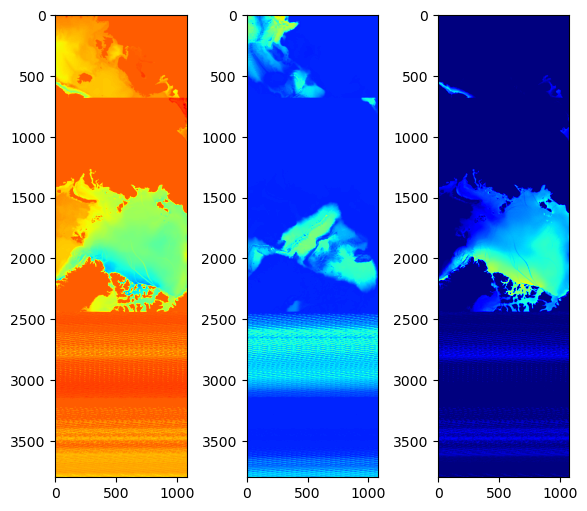

In [94]:
fig,axs = plt.subplots(1,3, figsize=[7,6])
axs[0].imshow(ocean_compact[0,:,:], origin='lower', cmap='jet')
axs[1].imshow(ocean_compact[1,:,:], origin='lower', cmap='jet')
axs[2].imshow(ocean_compact[2,:,:], origin='lower', cmap='jet')

for ax in axs:
    ax.invert_yaxis()

Sea Ice State 2D

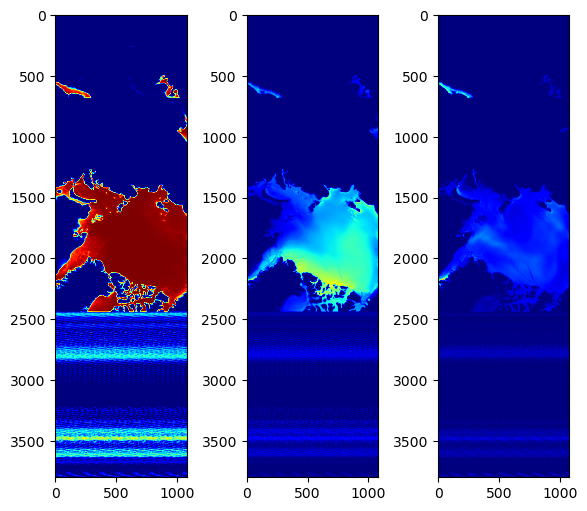

In [126]:
fig,axs = plt.subplots(1,3, figsize=[7,6])
axs[0].imshow(seaice_compact[0,:,:], origin='lower', cmap='jet')
axs[1].imshow(seaice_compact[1,:,:], origin='lower', cmap='jet')
axs[2].imshow(seaice_compact[2,:,:], origin='lower', cmap='jet')

for ax in axs:
    ax.invert_yaxis()

In [148]:
etan_faces     = sassie_n1_compact_to_faces(ocean_compact[0,:,:])
phibot_faces   = sassie_n1_compact_to_faces(ocean_compact[1,:,:])
SIceload_faces = sassie_n1_compact_to_faces(ocean_compact[2,:,:])

SIarea_faces  = sassie_n1_compact_to_faces(seaice_compact[0,:,:])
SIheff_faces  = sassie_n1_compact_to_faces(seaice_compact[1,:,:])
SIhsnow_faces = sassie_n1_compact_to_faces(seaice_compact[2,:,:])

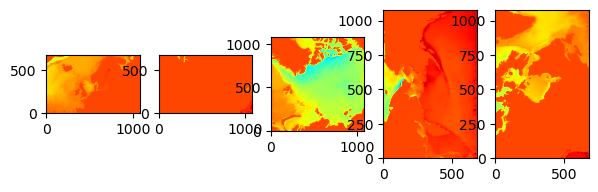

In [96]:
# replot
fig,axs = plt.subplots(1,5, figsize=[7,6])
axs[0].imshow(etan_faces[1], origin='lower', cmap='jet', vmin=-5, vmax=1)
axs[1].imshow(etan_faces[2], origin='lower', cmap='jet', vmin=-5, vmax=1)
axs[2].imshow(etan_faces[3], origin='lower', cmap='jet', vmin=-5, vmax=1)
axs[3].imshow(etan_faces[4], origin='lower', cmap='jet', vmin=-5, vmax=1)
axs[4].imshow(etan_faces[5], origin='lower', cmap='jet', vmin=-5, vmax=1)

# for ax in axs:
#     ax.invert_yaxis()

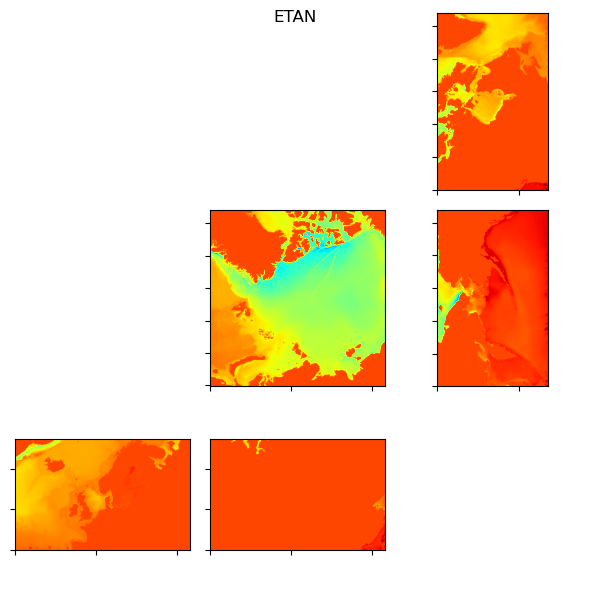

In [97]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(etan_faces[5], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[3].set_axis_off()
ax[4].imshow(etan_faces[3], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[5].imshow(etan_faces[4], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[6].imshow(etan_faces[1], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[7].imshow(etan_faces[2], origin='lower', cmap='jet', vmin=-5, vmax=1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.tight_layout()
plt.suptitle("ETAN");

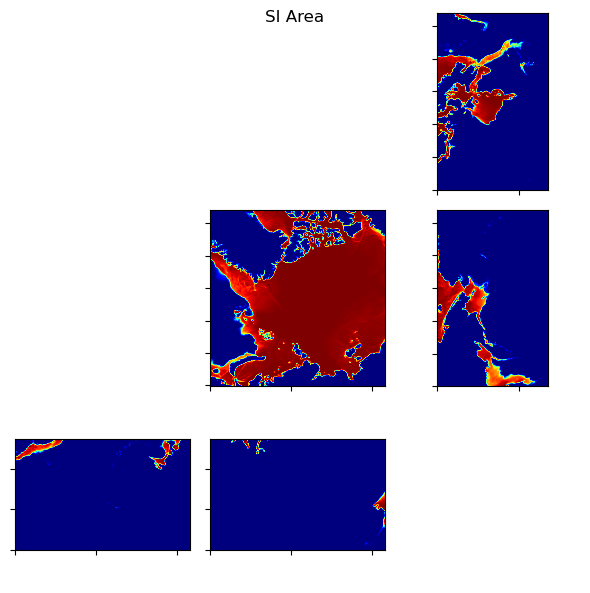

In [129]:
fig,axs = plt.subplots(3,3, figsize=[6,6])
ax = axs.ravel()
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].imshow(SIarea_faces[5], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[3].set_axis_off()
ax[4].imshow(SIarea_faces[3], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[5].imshow(SIarea_faces[4], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[6].imshow(SIarea_faces[1], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[7].imshow(SIarea_faces[2], origin='lower', cmap='jet', vmin=0, vmax=1)
ax[8].set_axis_off()

for ax in ax:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
plt.tight_layout()
plt.suptitle("SI Area");

In [149]:
## function to slice small pieces from Faces 1 and 4 and combine them to the Arctic Face 3
def combine_sassie_N1_faces_to_HH(face_arr):
    # dimensions of the final Arctic HH field. (180*2)+1080=1440
    new_arr = np.zeros((1080, 1440)) 
    # cut out sections we want and assign them to location on HH
    new_arr[:, 180:180 + 1080] = face_arr[3]
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, 0:180] = np.flipud(face_arr[1][-180:,:].T) # flip and transpose
    new_arr[:, 180 + 1080:] = face_arr[4][:,:180]

    new_arr = np.rot90(new_arr,2) # rotate it 180 so Greenland/AK are on bottom
    return new_arr

In [150]:
SIarea_faces_HH = combine_sassie_N1_faces_to_HH(SIarea_faces)

Text(0.5, 1.0, 'SI Area - HH')

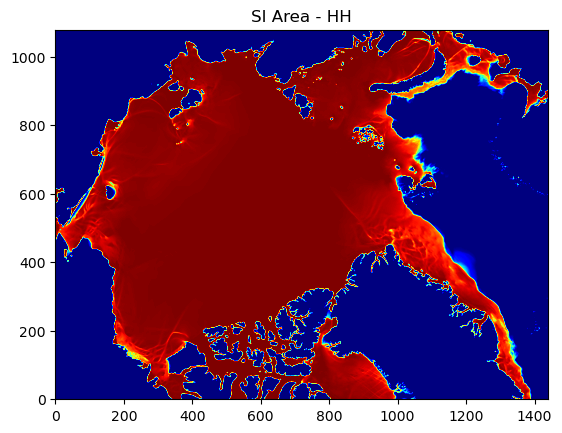

In [152]:
plt.imshow(SIarea_faces_HH, origin='lower', cmap='jet', vmin=0, vmax=1)
plt.title("SI Area - HH")

# Make Dataset

In [4]:
def create_encoding(G):
    # add coordinate attributes to the variables
    #coord_attrs, coord_G=  get_coordinate_attribute_to_data_vars(G)
    #print(coord_G)
    dv_coordinate_attrs = dict()

    for dv in list(G.data_vars):
        dv_coords_orig = set(list(G[dv].coords))

        #print(dv, dv_coords_orig)

        # REMOVE TIME STEP FROM LIST OF COORDINATES (PODAAC REQUEST)
        #coord_attrs[coord] = coord_attrs[coord].split('time_step')[0].strip()
        #data_var_coorcoord_attrs[coord].split()
        set_intersect = dv_coords_orig.intersection(set(['XC','YC','XG','YG','Z','Zl','Zu','time'])) #

        dv_coordinate_attrs[dv] = " ".join(set_intersect)

        #print(dv, dv_coordinate_attrs[dv])

                
    dv_encoding = dict()
    for dv in G.data_vars:
        dv_encoding[dv] =  {'zlib':True, \
                            'complevel':5,\
                            'shuffle':True,\
                            '_FillValue':None}
                            #'_FillValue':netcdf_fill_value}

        # overwrite default coordinats attribute (PODAAC REQUEST)
        G[dv].encoding['coordinates'] = dv_coordinate_attrs[dv]
        #print(G[dv].encoding)
        #dv_encoding[dv]['coordinates'] = dv_coordinate_attrs[dv]

    # PROVIDE SPECIFIC ENCODING DIRECTIVES FOR EACH COORDINATE
    print('\n... creating coordinate encodings')
    coord_encoding = dict()

    for coord in G.coords:
        # default encoding: no fill value, float32
        coord_encoding[coord] = {'_FillValue':None, 'dtype':'float32'}

        if (G[coord].values.dtype == np.int32) or \
           (G[coord].values.dtype == np.int64) :
            coord_encoding[coord]['dtype'] ='int32'

        if coord == 'time' or coord == 'time_bnds':
            coord_encoding[coord]['dtype'] ='int32'

            if 'units' in G[coord].attrs:
                # apply units as encoding for time
                coord_encoding[coord]['units'] = G[coord].attrs['units']
                # delete from the attributes list
                del G[coord].attrs['units']

        elif coord == 'time_step':
            coord_encoding[coord]['dtype'] ='int32'

    # MERGE ENCODINGS for coordinates and variables
    encoding = {**dv_encoding, **coord_encoding}
    return encoding

In [238]:
def add_geo_metadata(tmp_da):
    if 'XC' in list(tmp_da.coords):
        tmp_da['XC'].attrs['long_name'] = 'longitude of cell center'
        tmp_da['XC'].attrs['standard_name'] = 'longitude'
        tmp_da['XC'].attrs['units'] = 'degrees_east'
        
    if 'YC' in list(tmp_da.coords):
        tmp_da['YC'].attrs['long_name'] = 'latitude of cell center'
        tmp_da['YC'].attrs['standard_name'] = 'latitude'
        tmp_da['YC'].attrs['units'] = 'degrees_north'

    if 'i' in list(tmp_da.coords):
        tmp_da['i'].attrs['axis']  = 'X'
        tmp_da['i'].attrs['swap_dim']  = 'XC'

    if 'j' in list(tmp_da.coords):
        tmp_da['j'].attrs['axis']  = 'Y'
        tmp_da['j'].attrs['swap_dim']  = 'YC'

    if 'i_g' in list(tmp_da.coords):
        tmp_da['i_g'].attrs['axis']  = 'X'      
        
    if 'j_g' in list(tmp_da.coords):
        tmp_da['j_g'].attrs['axis']  = 'Y'        
    return tmp_da


Open geometry file created by Ian

In [163]:
sassie_n1_geometry_ds = xr.open_dataset('C:/Users/marie/Documents/SASSIE/SASSIE_downscale_ecco_v5/data/SASSIE_N1_geometry_v3.nc')

In [239]:
def make_2D_HH_da(field_HH, da_name, sassie_n1_geometry_ds):
    tmp_da = xr.DataArray(field_HH, dims=['j','i'],\
                            coords={'XC': (('j','i'), sassie_n1_geometry_ds.XC.values),\
                                    'YC': (('j','i'), sassie_n1_geometry_ds.YC.values)})
    
    tmp_da.name = da_name
    tmp_da = add_geo_metadata(tmp_da)
    
    return tmp_da

In [240]:
SIarea_da = make_2D_HH_da(SIarea_faces_HH, 'SIarea', sassie_n1_geometry_ds)

In [241]:
SIarea_da

<xarray.DataArray 'SIarea' (j: 1080, i: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    XC       (j, i) float32 -128.0 -128.0 -128.0 -128.0 ... 51.96 51.96 51.96
    YC       (j, i) float32 63.5 63.53 63.56 63.59 ... 63.59 63.56 63.53 63.5
Dimensions without coordinates: j, i

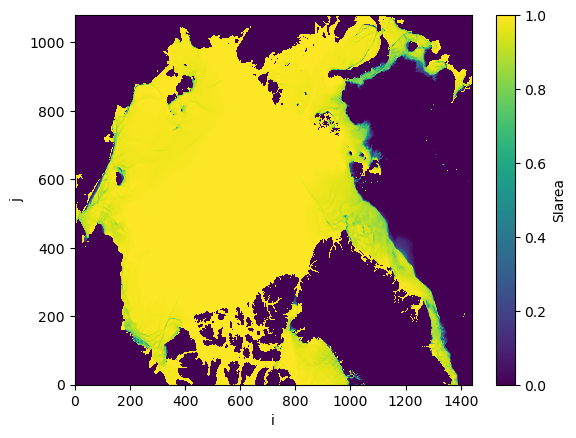

In [ ]:
SIarea_da.plot()

In [ ]:
import cartopy.crs as ccrs

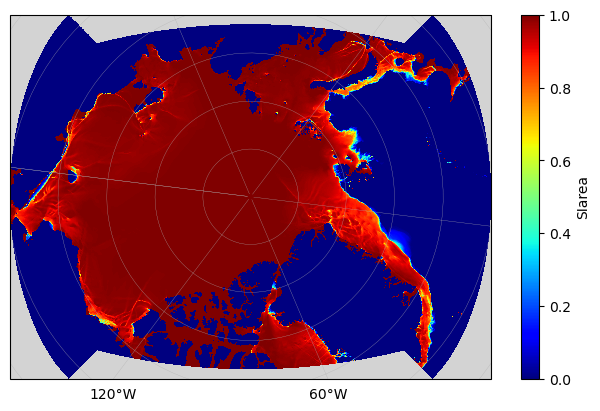

In [266]:
fig = plt.figure(figsize=(7,4), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -83))
# ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

SIarea_da.plot(x='XC',y='YC',ax=ax1,vmin=0,vmax=1,cmap='jet',transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
# ax1.set_title("depth=" + str(theta_350m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False